In [1]:
import os
import json
import numpy as np
import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.utils.data import DataLoader
from pprint import pprint
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt
from tqdm import tqdm
from conll import evaluate
from sklearn.metrics import classification_report
import random
import warnings
from statistics import mean

PAD_TOKEN=0
device = 'cuda:0'

# 1) Data preprocessing

### Import datasets

In [2]:
def load_data(path):
    '''
        input: path/to/data
        output: json 
    '''
    dataset = []
    with open(path) as f:
        dataset = json.loads(f.read())
    return dataset

In [3]:
ATIS_tmp_train_raw = load_data(os.path.join('data','ATIS','train.json'))
ATIS_test_raw = load_data(os.path.join('data','ATIS','test.json'))

In [4]:
SNIPS_train_raw = load_data(os.path.join('data','SNIPS','train.json'))
SNIPS_dev_raw= load_data(os.path.join('data','SNIPS','valid.json'))
SNIPS_test_raw = load_data(os.path.join('data','SNIPS','test.json'))

### Create development set

As suggested in class, we create a development set used for hyperparameter tuning using a stratification strategy in order to preserve the intents data distributions.
Since SNIPS dataset already comes with a validation set, the development set for this dataset is not created

In [5]:
#ATIS
# Firt we get the 10% of dataset, then we compute the percentage of these examples 
# on the training set which is around 11% 
portion = round(((len(ATIS_tmp_train_raw) + len(ATIS_test_raw)) * 0.10)/(len(ATIS_tmp_train_raw)),2)

intents = [x['intent'] for x in ATIS_tmp_train_raw] # We stratify on intents
count_y = Counter(intents)#For each class count the appearances

X = []
Y = []
mini_Train = []

for id_y, y in enumerate(intents):
    if count_y[y] > 1: # Some intents have only one instance, we put them in training
        X.append(ATIS_tmp_train_raw[id_y])
        Y.append(y)
    else:
        mini_Train.append(ATIS_tmp_train_raw[id_y])
# Random Stratify
ATIS_X_train, ATIS_X_dev, ATIS_y_train, ATIS_y_dev = train_test_split(X, Y, test_size=portion, 
                                                    random_state=42, 
                                                    shuffle=True,
                                                    stratify=Y)
ATIS_X_train.extend(mini_Train)
ATIS_train_raw = ATIS_X_train
ATIS_dev_raw = ATIS_X_dev

ATIS_y_test = [x['intent'] for x in ATIS_test_raw]

# Intent distribution
print('Train:')
pprint({k:round(v/len(ATIS_y_train),3)*100 for k, v in sorted(Counter(ATIS_y_train).items())})
print('Dev:'), 
pprint({k:round(v/len(ATIS_y_dev),3)*100 for k, v in sorted(Counter(ATIS_y_dev).items())})
print('Test:') 
pprint({k:round(v/len(ATIS_y_test),3)*100 for k, v in sorted(Counter(ATIS_y_test).items())})
print('='*89)
# Dataset size
print('TRAIN size:', len(ATIS_train_raw))
print('DEV size:', len(ATIS_dev_raw))
print('TEST size:', len(ATIS_test_raw))

Train:
{'abbreviation': 2.9000000000000004,
 'aircraft': 1.6,
 'airfare': 8.5,
 'airline': 3.2,
 'airline+flight_no': 0.0,
 'airport': 0.4,
 'capacity': 0.3,
 'city': 0.4,
 'distance': 0.4,
 'flight': 73.7,
 'flight+airfare': 0.4,
 'flight_no': 0.3,
 'flight_time': 1.0999999999999999,
 'ground_fare': 0.4,
 'ground_service': 5.1,
 'meal': 0.1,
 'quantity': 1.0,
 'restriction': 0.1}
Dev:
{'abbreviation': 3.0,
 'aircraft': 1.7000000000000002,
 'airfare': 8.5,
 'airline': 3.2,
 'airport': 0.3,
 'capacity': 0.3,
 'city': 0.3,
 'distance': 0.3,
 'flight': 73.7,
 'flight+airfare': 0.5,
 'flight_no': 0.2,
 'flight_time': 1.0,
 'ground_fare': 0.3,
 'ground_service': 5.2,
 'meal': 0.2,
 'quantity': 1.0,
 'restriction': 0.2}
Test:
{'abbreviation': 3.6999999999999997,
 'aircraft': 1.0,
 'airfare': 5.4,
 'airfare+flight': 0.1,
 'airline': 4.3,
 'airport': 2.0,
 'capacity': 2.4,
 'city': 0.7000000000000001,
 'day_name': 0.2,
 'distance': 1.0999999999999999,
 'flight': 70.8,
 'flight+airfare': 1.3,
 

In [6]:
"""#SNIPS
# Firt we get the 10% of dataset, then we compute the percentage of these examples 
# on the training set which is around 11% 
portion = round(((len(SNIPS_tmp_train_raw) + len(SNIPS_test_raw)) * 0.10)/(len(SNIPS_tmp_train_raw)),2)

intents = [x['intent'] for x in SNIPS_tmp_train_raw] # We stratify on intents
count_y = Counter(intents)#For each class count the appearances

X = []
Y = []
mini_Train = []

for id_y, y in enumerate(intents):
    if count_y[y] > 1: # Some intents have only one instance, we put them in training
        X.append(SNIPS_tmp_train_raw[id_y])
        Y.append(y)
    else:
        mini_Train.append(SNIPS_tmp_train_raw[id_y])
# Random Stratify
SNIPS_X_train, SNIPS_X_dev, SNIPS_y_train, SNIPS_y_dev = train_test_split(X, Y, test_size=portion, 
                                                    random_state=42, 
                                                    shuffle=True,
                                                    stratify=Y)
SNIPS_X_train.extend(mini_Train)
SNIPS_train_raw = SNIPS_X_train
SNIPS_dev_raw = SNIPS_X_dev

SNIPS_y_test = [x['intent'] for x in SNIPS_test_raw]

# Intent distribution
print('Train:')
pprint({k:round(v/len(SNIPS_y_train),3)*100 for k, v in sorted(Counter(SNIPS_y_train).items())})
print('Dev:'), 
pprint({k:round(v/len(SNIPS_y_dev),3)*100 for k, v in sorted(Counter(SNIPS_y_dev).items())})
print('Test:') 
pprint({k:round(v/len(SNIPS_y_test),3)*100 for k, v in sorted(Counter(SNIPS_y_test).items())})
print('='*89)
# Dataset size
print('TRAIN size:', len(SNIPS_train_raw))
print('DEV size:', len(SNIPS_dev_raw))
print('TEST size:', len(SNIPS_test_raw))"""

"#SNIPS\n# Firt we get the 10% of dataset, then we compute the percentage of these examples \n# on the training set which is around 11% \nportion = round(((len(SNIPS_tmp_train_raw) + len(SNIPS_test_raw)) * 0.10)/(len(SNIPS_tmp_train_raw)),2)\n\nintents = [x['intent'] for x in SNIPS_tmp_train_raw] # We stratify on intents\ncount_y = Counter(intents)#For each class count the appearances\n\nX = []\nY = []\nmini_Train = []\n\nfor id_y, y in enumerate(intents):\n    if count_y[y] > 1: # Some intents have only one instance, we put them in training\n        X.append(SNIPS_tmp_train_raw[id_y])\n        Y.append(y)\n    else:\n        mini_Train.append(SNIPS_tmp_train_raw[id_y])\n# Random Stratify\nSNIPS_X_train, SNIPS_X_dev, SNIPS_y_train, SNIPS_y_dev = train_test_split(X, Y, test_size=portion, \n                                                    random_state=42, \n                                                    shuffle=True,\n                                                    stratify=Y

### Lang Class

Class handling conversion of words/slots/intents to ids and viceversa

In [7]:
class Lang():
    def __init__(self, words, intents, slots, cutoff=0):
        self.word2id = self.w2id(words, cutoff=cutoff, unk=True)
        self.slot2id = self.lab2id(slots)
        self.intent2id = self.lab2id(intents, pad=False)
        self.id2word = {v:k for k, v in self.word2id.items()}
        self.id2slot = {v:k for k, v in self.slot2id.items()}
        self.id2intent = {v:k for k, v in self.intent2id.items()}
        
    def w2id(self, elements, cutoff=None, unk=True):
        vocab = {'pad': PAD_TOKEN}
        if unk:
            vocab['unk'] = len(vocab)
        count = Counter(elements)
        for k, v in count.items():
            if v > cutoff:
                vocab[k] = len(vocab)
        return vocab
    
    def lab2id(self, elements, pad=True):
        vocab = {}
        if pad:
            vocab['pad'] = PAD_TOKEN
        for elem in elements:
                vocab[elem] = len(vocab)
        return vocab

In [8]:
#ATIS
ATIS_words = sum([x['utterance'].split() for x in ATIS_train_raw], []) # No set() since we want to compute 
                                                            # the cutoff
ATIS_corpus = ATIS_train_raw + ATIS_dev_raw + ATIS_test_raw # We do not want unk labels, 
                                        # however this depends on the research purpose
ATIS_slots = set(sum([line['slots'].split() for line in ATIS_corpus],[])) # the type of slots
ATIS_intents = set([line['intent'] for line in ATIS_corpus]) #all the intent types

ATIS_lang = Lang(ATIS_words, ATIS_intents, ATIS_slots, cutoff=0)

print('# Words:', len(ATIS_lang.word2id)-2) # we remove pad and unk from the count
print('# Slots:', len(ATIS_lang.slot2id)-1)
print('# Intents:', len(ATIS_lang.intent2id))

# Words: 861
# Slots: 129
# Intents: 26


In [9]:
#SNIPS
SNIPS_words = sum([x['utterance'].split() for x in SNIPS_train_raw], []) # No set() since we want to compute 
                                                            # the cutoff
SNIPS_corpus = SNIPS_train_raw + SNIPS_dev_raw + SNIPS_test_raw # We do not want unk labels, 
                                        # however this depends on the research purpose
SNIPS_slots = set(sum([line['slots'].split() for line in SNIPS_corpus],[])) # the type of slots
SNIPS_intents = set([line['intent'] for line in SNIPS_corpus]) #all the intent types

SNIPS_lang = Lang(SNIPS_words, SNIPS_intents, SNIPS_slots, cutoff=0)

print('# Words:', len(SNIPS_lang.word2id)-2) # we remove pad and unk from the count
print('# Slots:', len(SNIPS_lang.slot2id)-1)
print('# Intents:', len(SNIPS_lang.intent2id))

# Words: 11417
# Slots: 72
# Intents: 7


### Dataset class

In [10]:
class IntentsAndSlots (data.Dataset):
    # Mandatory methods are __init__, __len__ and __getitem__
    def __init__(self, dataset, lang, unk='unk'):
        self.utterances = []
        self.intents = []
        self.slots = []
        self.unk = unk
        
        for x in dataset:
            self.utterances.append(x['utterance'])
            self.slots.append(x['slots'])
            self.intents.append(x['intent'])

        self.utt_ids = self.mapping_seq(self.utterances, lang.word2id)
        self.slot_ids = self.mapping_seq(self.slots, lang.slot2id)
        self.intent_ids = self.mapping_lab(self.intents, lang.intent2id)

    def __len__(self):
        return len(self.utterances)

    def __getitem__(self, idx):
        utt = torch.Tensor(self.utt_ids[idx])
        slots = torch.Tensor(self.slot_ids[idx])
        intent = self.intent_ids[idx]
        sample = {'utterance': utt, 'slots': slots, 'intent': intent}
        return sample
    
    # Auxiliary methods
    
    def mapping_lab(self, data, mapper):
        return [mapper[x] if x in mapper else mapper[self.unk] for x in data]
    
    def mapping_seq(self, data, mapper): # Map sequences to number
        res = []
        for seq in data:
            tmp_seq = []
            for x in seq.split():
                if x in mapper:
                    tmp_seq.append(mapper[x])
                else:
                    tmp_seq.append(mapper[self.unk])
            res.append(tmp_seq)
        return res

In [11]:
#ATIS_ dataset
ATIS_train_dataset = IntentsAndSlots(ATIS_train_raw, ATIS_lang)
ATIS_dev_dataset = IntentsAndSlots(ATIS_dev_raw, ATIS_lang)
ATIS_test_dataset = IntentsAndSlots(ATIS_test_raw, ATIS_lang)

In [12]:
#SNIPS_ dataset
SNIPS_train_dataset = IntentsAndSlots(SNIPS_train_raw, SNIPS_lang)
SNIPS_dev_dataset = IntentsAndSlots(SNIPS_dev_raw, SNIPS_lang)
SNIPS_test_dataset = IntentsAndSlots(SNIPS_test_raw, SNIPS_lang)

### Dataloader

In [13]:
def collate_fn(data):
    def merge(sequences):
        '''
        merge from batch * sent_len to batch * max_len 
        '''
        lengths = [len(seq) for seq in sequences]
        max_len = 1 if max(lengths)==0 else max(lengths)
        # Pad token is zero in our case
        # So we create a matrix full of PAD_TOKEN (i.e. 0) with the shape 
        # batch_size X maximum length of a sequence
        padded_seqs = torch.LongTensor(len(sequences),max_len).fill_(PAD_TOKEN)
        for i, seq in enumerate(sequences):
            end = lengths[i]
            padded_seqs[i, :end] = seq # We copy each sequence into the matrix
        # print(padded_seqs)
        padded_seqs = padded_seqs.detach()  # We remove these tensors from the computational graph
        return padded_seqs, lengths
    # Sort data by seq lengths
    data.sort(key=lambda x: len(x['utterance']), reverse=True) 
    new_item = {}
    for key in data[0].keys():
        new_item[key] = [d[key] for d in data]
    # We just need one length for packed pad seq, since len(utt) == len(slots)
    src_utt, _ = merge(new_item['utterance'])
    y_slots, y_lengths = merge(new_item["slots"])
    intent = torch.LongTensor(new_item["intent"])
    
    src_utt = src_utt.to(device) # We load the Tensor on our seleceted device
    y_slots = y_slots.to(device)
    intent = intent.to(device)
    y_lengths = torch.LongTensor(y_lengths).to(device)
    
    new_item["utterances"] = src_utt
    new_item["intents"] = intent
    new_item["y_slots"] = y_slots
    new_item["slots_len"] = y_lengths
    return new_item

In [14]:
#ATIS_ Dataloader instantiation
ATIS_train_loader = DataLoader(ATIS_train_dataset, batch_size=128, collate_fn=collate_fn,  shuffle=True)
ATIS_dev_loader = DataLoader(ATIS_dev_dataset, batch_size=64, collate_fn=collate_fn)
ATIS_test_loader = DataLoader(ATIS_test_dataset, batch_size=64, collate_fn=collate_fn)

In [15]:
#SNIPS_ Dataloader instantiation
SNIPS_train_loader = DataLoader(SNIPS_train_dataset, batch_size=128, collate_fn=collate_fn,  shuffle=True)
SNIPS_dev_loader = DataLoader(SNIPS_dev_dataset, batch_size=64, collate_fn=collate_fn)
SNIPS_test_loader = DataLoader(SNIPS_test_dataset, batch_size=64, collate_fn=collate_fn)

### Weight initialization

Function to randomly initialize the weights of Neural Networks in Pytorch

In [16]:
def init_weights(mat):
    for m in mat.modules():
        if type(m) in [nn.GRU, nn.LSTM, nn.RNN]:
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.xavier_uniform_(param[idx*mul:(idx+1)*mul])
                elif 'weight_hh' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.orthogonal_(param[idx*mul:(idx+1)*mul])
                elif 'bias' in name:
                    param.data.fill_(0)
        else:
            if type(m) in [nn.Linear]:
                torch.nn.init.uniform_(m.weight, -0.01, 0.01)
                if m.bias != None:
                    m.bias.data.fill_(0.01)

### Evaluation Loop and Predict method

In [17]:
def eval_loop(data, criterion_slots, criterion_intents, model, lang):
    model.eval()
    loss_array = []
    
    ref_intents = []
    hyp_intents = []
    
    ref_slots = []
    hyp_slots = []
    #softmax = nn.Softmax(dim=1) # Use Softmax if you need the actual probability
    with torch.no_grad(): # It used to avoid the creation of computational graph
        for sample in data:
            slots, intents = model(sample['utterances'], sample['slots_len'])
            loss_intent = criterion_intents(intents, sample['intents'])
            loss_slot = criterion_slots(slots, sample['y_slots'])
            loss = loss_intent + loss_slot 
            loss_array.append(loss.item())
            # Intent inference
            # Get the highest probable class
            out_intents = [lang.id2intent[x] 
                           for x in torch.argmax(intents, dim=1).tolist()] 
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)
            
            # Slot inference 
            output_slots = torch.argmax(slots, dim=1)
            for id_seq, seq in enumerate(output_slots):
                length = sample['slots_len'].tolist()[id_seq]
                utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq].tolist()
                gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]]
                utterance = [lang.id2word[elem] for elem in utt_ids]
                to_decode = seq[:length].tolist()
                ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
                tmp_seq = []
                for id_el, elem in enumerate(to_decode):
                    #tmp_seq.append((utterance[id_el], lang.id2slot[elem]))
                    tmp_seq.append((utterance[id_el], lang.id2slot[elem]) if elem != 0 else (utterance[id_el], 'O'))
                hyp_slots.append(tmp_seq)
    try:
        """print(len(ref_slots))
        print(len(hyp_slots))
        print(len(ref_slots[0]))
        print(len(hyp_slots[0]))"""
        results = evaluate(ref_slots, hyp_slots)
    except Exception as ex:
        # Sometimes the model predics a class that is not in REF
        print(ex)
        ref_s = set([x[1] for x in ref_slots])
        hyp_s = set([x[1] for x in hyp_slots])
        print(hyp_s.difference(ref_s))
        
    report_intent = classification_report(ref_intents, hyp_intents, 
                                          zero_division=False, output_dict=True)
    return results, report_intent, loss_array


In [18]:
def predict(data, criterion_slots, criterion_intents, model, lang):
    model.eval()
    loss_array = []
    
    ref_intents = []
    hyp_intents = []
    
    ref_slots = []
    hyp_slots = []
    #softmax = nn.Softmax(dim=1) # Use Softmax if you need the actual probability
    with torch.no_grad(): # It used to avoid the creation of computational graph
        for sample in data:
            slots, intents = model(sample['utterances'], sample['slots_len'])
            loss_intent = criterion_intents(intents, sample['intents'])
            loss_slot = criterion_slots(slots, sample['y_slots'])
            loss = loss_intent + loss_slot 
            loss_array.append(loss.item())
            # Intent inference
            # Get the highest probable class
            out_intents = [lang.id2intent[x] 
                           for x in torch.argmax(intents, dim=1).tolist()] 
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)
            
            # Slot inference 
            output_slots = torch.argmax(slots, dim=1)
            for id_seq, seq in enumerate(output_slots):
                length = sample['slots_len'].tolist()[id_seq]
                utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq].tolist()
                gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]]
                utterance = [lang.id2word[elem] for elem in utt_ids]
                to_decode = seq[:length].tolist()
                ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
                tmp_seq = []
                for id_el, elem in enumerate(to_decode):
                    tmp_seq.append((utterance[id_el], lang.id2slot[elem]))
                hyp_slots.append(tmp_seq)
    try:            
        results = evaluate(ref_slots, hyp_slots)
    except Exception as ex:
        # Sometimes the model predics a class that is not in REF
        print(ex)
        ref_s = set([x[1] for x in ref_slots])
        hyp_s = set([x[1] for x in hyp_slots])
        print(hyp_s.difference(ref_s))
        
    return hyp_intents,ref_intents,hyp_slots,ref_slots


### Error Analysis Methods

In [19]:
#Intent accuracy by sentence lenght, provides bar plot with intent accuracy per sentence lenght, useful to detect potential deficits in long sentences
def intent_acc_lenght(intent_hyp,intent_gt, ATIS=True):
    dataset=""
    if(ATIS):
        dataset="ATIS"
    else:
        dataset="SNIPS"
    test_results=[]
    for i in range(0,50):
        test_results.append([])
    for i in range(0,len(intent_hyp)):
        sent_lenght=len(slot_gt[i])
        #print(sent_lenght)
        test_results[sent_lenght].append((intent_hyp[i],intent_gt[i]))

    #Measure accuracy at each sentence lenght
    pred=[]
    true=[]
    sent_length=[]
    accuracy_values=[]
    accuracy_lenght=[]
    for index in range(0,50):
        if(len(test_results[index])!=0):
            for (hyp, gt) in test_results[index]:
                pred.append(hyp)
                true.append(gt)
            print("Accuracy at sentence lenght ",index,"=",intent_accuracy(pred, true))
            sent_length.append(index)
            accuracy_values.append(intent_accuracy(pred, true))

    #Plot results
    print("="*85)
    print(dataset," Intent Accuracy by sentence length")
    plt.xticks(sent_length)

    plt.bar(sent_length,accuracy_values,width=0.8)
    plt.show()
    #Plot results

In [28]:
def intent_confusion_matrix():
    return 0

In [ ]:
def best_intent_acc():
    return 0

In [ ]:
def worst_intent_acc():
    return 0

In [ ]:
def best_slots():
    return 0

In [ ]:
def worst_slots():
    return 0

# 2) Baseline Model

As a baseline model i took the Neural Network that was presented during lab experience #10

In [20]:
class ModelIAS(nn.Module):

    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=1, pad_index=0):
        super(ModelIAS, self).__init__()
        # hid_size = Hidden size
        # out_slot = number of slots (output size for slot filling)
        # out_int = number of intents (ouput size for intent class)
        # emb_size = word embedding size
        
        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)
        
        self.utt_encoder = nn.LSTM(emb_size, hid_size, n_layer, bidirectional=False)    
        self.slot_out = nn.Linear(hid_size, out_slot)
        self.intent_out = nn.Linear(hid_size, out_int)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, utterance, seq_lengths):
        # utterance.size() = batch_size X seq_len
        utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size
        utt_emb = utt_emb.permute(1,0,2) # we need seq len first -> seq_len X batch_size X emb_size
        
        # pack_padded_sequence avoid computation over pad tokens reducing the computational cost
        
        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu().numpy())
        # Process the batch
        packed_output, (last_hidden, cell) = self.utt_encoder(packed_input) 
        # Unpack the sequence
        utt_encoded, input_sizes = pad_packed_sequence(packed_output)
        # Get the last hidden state
        last_hidden = last_hidden[-1,:,:]
        # Compute slot logits
        slots = self.slot_out(utt_encoded)
        # Compute intent logits
        intent = self.intent_out(last_hidden)
        
        # Slot size: seq_len, batch size, calsses 
        slots = slots.permute(1,2,0) # We need this for computing the loss
        # Slot size: batch_size, classes, seq_len
        return slots, intent

### Hyperparameters

In [21]:
hid_size = 200
emb_size = 300

lr = 0.0001 # learning rate
clip = 5 # Clip the gradient

ATIS_out_slot = len(ATIS_lang.slot2id)
ATIS_out_int = len(ATIS_lang.intent2id)
ATIS_vocab_len = len(ATIS_lang.word2id)

SNIPS_out_slot = len(SNIPS_lang.slot2id)
SNIPS_out_int = len(SNIPS_lang.intent2id)
SNIPS_vocab_len = len(SNIPS_lang.word2id)

### Training loop

In [22]:
def train_loop(data, optimizer, criterion_slots, criterion_intents, model):
    model.train()
    loss_array = []
    for sample in data:
        optimizer.zero_grad() # Zeroing the gradient
        slots, intent = model(sample['utterances'], sample['slots_len'])
        loss_intent = criterion_intents(intent, sample['intents'])
        loss_slot = criterion_slots(slots, sample['y_slots'])
        loss = loss_intent + loss_slot # In joint training we sum the losses. 
                                       # Is there another way to do that?
        loss_array.append(loss.item())
        loss.backward() # Compute the gradient, deleting the computational graph
        # clip the gradient to avoid explosioning gradients
        # torch.nn.utils.clip_grad_norm_(model.parameters(), clip)  
        optimizer.step() # Update the weights
    return loss_array

### Training procedure

Multiple runs are made to compute accuracy and f1 mean and standard deviation

In [23]:
#ATIS
n_epochs = 200
early_stopping=3
patience = early_stopping
losses_train = []
losses_dev = []
sampled_epochs = []
best_f1 = 0

runs = 5
slot_f1s, intent_acc = [], []
for x in tqdm(range(0, runs)):
    ATIS_model = ModelIAS(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
    ATIS_model.apply(init_weights)
    
    ATIS_optimizer = optim.Adam(ATIS_model.parameters(), lr=lr)
    ATIS_criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
    ATIS_criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token
    
    n_epochs = 200
    early_stopping=3
    patience = early_stopping
    losses_train = []
    losses_dev = []
    sampled_epochs = []
    best_f1 = 0

    for x in range(1,n_epochs):
        
        loss = train_loop(ATIS_train_loader, ATIS_optimizer, ATIS_criterion_slots, 
                      ATIS_criterion_intents, ATIS_model)
        if x % 5 == 0:
            sampled_epochs.append(x)
            losses_train.append(np.asarray(loss).mean())
            results_dev=""
            results_dev, intent_res, loss_dev = eval_loop(ATIS_dev_loader, ATIS_criterion_slots, 
                                                          ATIS_criterion_intents, ATIS_model, ATIS_lang)
            losses_dev.append(np.asarray(loss_dev).mean())
            f1 = results_dev['total']['f']

            if f1 > best_f1:
                best_f1 = f1
            else:
                patience -= 1
            if patience <= 0: # Early stoping with patient
                break # Not nice but it keeps the code clean

    ATIS_results_test, ATIS_intent_test, _ = eval_loop(ATIS_test_loader, ATIS_criterion_slots, 
                                         ATIS_criterion_intents, ATIS_model, ATIS_lang)
    intent_acc.append(ATIS_intent_test['accuracy'])
    slot_f1s.append(ATIS_results_test['total']['f'])



slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)
print('Slot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(slot_f1s.std(), 3))

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:28<00:00, 65.78s/it]

Slot F1 0.919 +- 0.005
Intent Acc 0.937 +- 0.005


In [24]:
#SNIPS
n_epochs = 200
early_stopping=3
patience = early_stopping
losses_train = []
losses_dev = []
sampled_epochs = []
best_f1 = 0

runs = 5
slot_f1s, intent_acc = [], []
for x in tqdm(range(0, runs)):
    SNIPS_model = ModelIAS(hid_size, SNIPS_out_slot, SNIPS_out_int, emb_size, SNIPS_vocab_len, pad_index=PAD_TOKEN).to(device)
    SNIPS_model.apply(init_weights)
    
    SNIPS_optimizer = optim.Adam(SNIPS_model.parameters(), lr=lr)
    SNIPS_criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
    SNIPS_criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token
    
    n_epochs = 200
    early_stopping=3
    patience = early_stopping
    losses_train = []
    losses_dev = []
    sampled_epochs = []
    best_f1 = 0

    for x in range(1,n_epochs):
        
        loss = train_loop(SNIPS_train_loader, SNIPS_optimizer, SNIPS_criterion_slots, 
                      SNIPS_criterion_intents, SNIPS_model)
        if x % 5 == 0:
            sampled_epochs.append(x)
            losses_train.append(np.asarray(loss).mean())
            results_dev, intent_res, loss_dev = eval_loop(SNIPS_dev_loader, SNIPS_criterion_slots, 
                                                          SNIPS_criterion_intents, SNIPS_model, SNIPS_lang)
            losses_dev.append(np.asarray(loss_dev).mean())
            f1 = results_dev['total']['f']

            if f1 > best_f1:
                best_f1 = f1
            else:
                patience -= 1
            if patience <= 0: # Early stoping with patient
                break # Not nice but it keeps the code clean

    SNIPS_results_test, SNIPS_intent_test, _ = eval_loop(SNIPS_test_loader, SNIPS_criterion_slots, 
                                         SNIPS_criterion_intents, SNIPS_model, SNIPS_lang)
    intent_acc.append(SNIPS_intent_test['accuracy'])
    slot_f1s.append(SNIPS_results_test['total']['f'])



slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)
print('Slot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(slot_f1s.std(), 3))

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:16<00:00, 99.33s/it]

Slot F1 0.803 +- 0.01
Intent Acc 0.966 +- 0.01


## Error Analysis

### Intent Detection Accuracy by Utterance length

In [25]:
def intent_accuracy(pred,gt):
    lenght=len(pred)
    correct=0
    for i in range(0,lenght):
        if(pred[i]==gt[i]):
            correct+=1
    return correct/lenght

Accuracy at sentence lenght  2 = 0.5
Accuracy at sentence lenght  3 = 0.8181818181818182
Accuracy at sentence lenght  4 = 0.9534883720930233
Accuracy at sentence lenght  5 = 0.9743589743589743
Accuracy at sentence lenght  6 = 0.9323308270676691
Accuracy at sentence lenght  7 = 0.9227053140096618
Accuracy at sentence lenght  8 = 0.935064935064935
Accuracy at sentence lenght  9 = 0.9407582938388626
Accuracy at sentence lenght  10 = 0.9512670565302144
Accuracy at sentence lenght  11 = 0.9533333333333334
Accuracy at sentence lenght  12 = 0.9493293591654247
Accuracy at sentence lenght  13 = 0.9504814305364512
Accuracy at sentence lenght  14 = 0.9481193255512321
Accuracy at sentence lenght  15 = 0.944792973651192
Accuracy at sentence lenght  16 = 0.9449101796407186
Accuracy at sentence lenght  17 = 0.943089430894309
Accuracy at sentence lenght  18 = 0.9421965317919075
Accuracy at sentence lenght  19 = 0.9425287356321839
Accuracy at sentence lenght  20 = 0.9406392694063926
Accuracy at sentenc

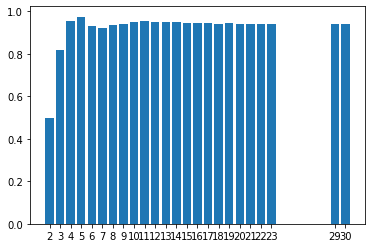

In [26]:
#ATIS
intent_hyp,intent_gt,slot_hyp,slot_gt=predict(ATIS_test_loader, ATIS_criterion_slots,
                                              ATIS_criterion_intents, ATIS_model, ATIS_lang)
#Slot is array of array, intent is array of strings

#Get an array of (predictions,ground truth) based on utterance length
intent_acc_lenght(intent_hyp,intent_gt, ATIS=True)

Accuracy at sentence lenght  3 = 1.0
Accuracy at sentence lenght  4 = 0.9142857142857143
Accuracy at sentence lenght  5 = 0.963855421686747
Accuracy at sentence lenght  6 = 0.9503105590062112
Accuracy at sentence lenght  7 = 0.9612403100775194
Accuracy at sentence lenght  8 = 0.9567723342939481
Accuracy at sentence lenght  9 = 0.9624413145539906
Accuracy at sentence lenght  10 = 0.9650924024640657
Accuracy at sentence lenght  11 = 0.9656419529837251
Accuracy at sentence lenght  12 = 0.9679595278246206
Accuracy at sentence lenght  13 = 0.9681020733652312
Accuracy at sentence lenght  14 = 0.9662058371735791
Accuracy at sentence lenght  15 = 0.9669669669669669
Accuracy at sentence lenght  16 = 0.967741935483871
Accuracy at sentence lenght  17 = 0.9666182873730044
Accuracy at sentence lenght  18 = 0.9667630057803468
Accuracy at sentence lenght  19 = 0.9668587896253602
Accuracy at sentence lenght  20 = 0.9670014347202296
Accuracy at sentence lenght  21 = 0.9670487106017192
Accuracy at sente

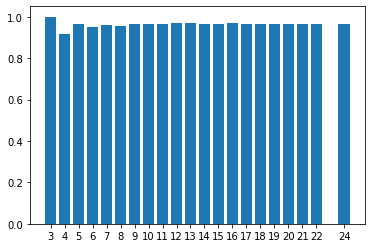

In [27]:
#SNIPS
intent_hyp,intent_gt,slot_hyp,slot_gt=predict(SNIPS_test_loader, SNIPS_criterion_slots,
                                              SNIPS_criterion_intents, SNIPS_model, SNIPS_lang)
#Slot is array of array, intent is array of strings
#Get an array of (predictions,ground truth) based on utterance length
intent_acc_lenght(intent_hyp,intent_gt, ATIS=True)

### Slot F1 by utterance lenght


# 3) Second Model - Bi-Directional Encoder with GRU

The idea of this second model is to take the architecture of the baseline and apply improvements.
The overall structure is still the same, with a joint encoder used for both Slot-Filling and Intent-Detection task and apply two separate classifiers at the end, one for each task.

However, the 1-layer, monodirectional LSTM has been replaced by a bi-directional 2 layer GRU.
The structure of the GRU implies a reduction in trainable parameters compared to LSTM, speeding up the training process and reducing the risk of overfitting.

Thanks to the speeding up in training time, a layer was added to the encoder that resulted in an increase in accuracy.
Deeper architecture with more layers were tried but were much slower in training and did not produce improvements during the evaluation compared to the 2 layer model.

Also, a change in the loss computation is made:

$Loss= \alpha * Loss_i + \beta * Loss_s$

where:

- $Loss_i$ is the intent detection task loss 
- $Loss_s$ is slot filling task loss
- $\alpha + \beta = 1$

In [25]:
class BiGRU(nn.Module):
    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=2, pad_index=0):
        super(BiGRU, self).__init__()
        # hid_size = Hidden size
        # out_slot = number of slots (output size for slot filling)
        # out_int = number of intents (ouput size for intent class)
        # emb_size = word embedding size
        
        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)
        
        self.utt_encoder = nn.GRU(emb_size, hid_size, n_layer,dropout=0.4, bidirectional=True)    
        self.slot_out = nn.Linear(hid_size*2, out_slot)
        self.intent_out = nn.Linear(hid_size, out_int)
        self.dropout = nn.Dropout(0.4)
        
    def forward(self, utterance, seq_lengths):
        # utterance.size() = batch_size X seq_len
        utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size
        utt_emb = utt_emb.permute(1,0,2) # we need seq len first -> seq_len X batch_size X emb_size
        
        # pack_padded_sequence avoid computation over pad tokens reducing the computational cost
        
        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu().numpy())
        # Process the batch
        packed_output, last_hidden = self.utt_encoder(packed_input) 
        
        # Unpack the sequence
        utt_encoded, input_sizes = pad_packed_sequence(packed_output)
        # Get the last hidden state
        last_hidden = last_hidden[-1,:,:]
        
        
        # Compute slot logits
        slots = self.slot_out(utt_encoded)
        # Compute intent logits
        intent = self.intent_out(last_hidden)
        
        # Slot size: seq_len, batch size, calsses 
        slots = slots.permute(1,2,0) # We need this for computing the loss
        # Slot size: batch_size, classes, seq_len
        return slots, intent

### Hyperparameters

In [26]:
hid_size = 200
emb_size = 300

lr = 0.0005 # learning rate
clip = 5 # Clip the gradient

ATIS_out_slot = len(ATIS_lang.slot2id)
ATIS_out_int = len(ATIS_lang.intent2id)
ATIS_vocab_len = len(ATIS_lang.word2id)

SNIPS_out_slot = len(SNIPS_lang.slot2id)
SNIPS_out_int = len(SNIPS_lang.intent2id)
SNIPS_vocab_len = len(SNIPS_lang.word2id)

### Train Loop

In [30]:
def train_loop_bigru(data, optimizer, criterion_slots, criterion_intents, model):
    model.train()
    loss_array = []
    for sample in data:
        optimizer.zero_grad() # Zeroing the gradient
        slots, intent = model(sample['utterances'], sample['slots_len'])
        loss_intent = criterion_intents(intent, sample['intents'])
        loss_slot = criterion_slots(slots, sample['y_slots'])
        
        alpha=random.uniform(0, 1)
        beta=1-alpha
        
        #alpha=0.3
        #beta=0.7
        
        loss=max(alpha,beta) * loss_slot + min(alpha,beta) * loss_intent
        
        loss_array.append(loss.item())
        loss.backward() # Compute the gradient, deleting the computational graph
        # clip the gradient to avoid explosioning gradients
        # torch.nn.utils.clip_grad_norm_(model.parameters(), clip)  
        optimizer.step() # Update the weights
    return loss_array

In [31]:
#ATIS
n_epochs = 200
early_stopping=3
patience = early_stopping
losses_train = []
losses_dev = []
sampled_epochs = []
best_f1 = 0

runs = 5
slot_f1s, intent_acc = [], []
for x in tqdm(range(0, runs)):
    ATIS_bigru = BiGRU(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
    ATIS_bigru.apply(init_weights)
    
    ATIS_optimizer = optim.Adam(ATIS_bigru.parameters(), lr=lr)
    ATIS_criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
    ATIS_criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token
    
    n_epochs = 200
    early_stopping=3
    patience = early_stopping
    losses_train = []
    losses_dev = []
    sampled_epochs = []
    best_f1 = 0

    for x in range(1,n_epochs):
        
        loss = train_loop_bigru(ATIS_train_loader, ATIS_optimizer, ATIS_criterion_slots, 
                      ATIS_criterion_intents, ATIS_bigru)
        if x % 5 == 0:
            sampled_epochs.append(x)
            losses_train.append(np.asarray(loss).mean())
            results_dev=""
            results_dev, intent_res, loss_dev = eval_loop(ATIS_dev_loader, ATIS_criterion_slots, 
                                                          ATIS_criterion_intents, ATIS_bigru, ATIS_lang)
            losses_dev.append(np.asarray(loss_dev).mean())
            f1 = results_dev['total']['f']

            if f1 > best_f1:
                best_f1 = f1
            else:
                patience -= 1
            if patience <= 0: # Early stoping with patient
                break # Not nice but it keeps the code clean

    ATIS_results_test, ATIS_intent_test, _ = eval_loop(ATIS_test_loader, ATIS_criterion_slots, 
                                         ATIS_criterion_intents, ATIS_bigru, ATIS_lang)
    intent_acc.append(ATIS_intent_test['accuracy'])
    slot_f1s.append(ATIS_results_test['total']['f'])



slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)
print("ATIS")
print('Slot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(slot_f1s.std(), 3))

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:04<00:00, 36.86s/it]

ATIS
Slot F1 0.949 +- 0.001
Intent Acc 0.956 +- 0.001


In [32]:
#SNIPS
n_epochs = 200
early_stopping=3
patience = early_stopping
losses_train = []
losses_dev = []
sampled_epochs = []
best_f1 = 0

runs = 5
slot_f1s, intent_acc = [], []
for x in tqdm(range(0, runs)):
    SNIPS_bigru = BiGRU(hid_size, SNIPS_out_slot, SNIPS_out_int, emb_size, SNIPS_vocab_len, pad_index=PAD_TOKEN).to(device)
    SNIPS_bigru.apply(init_weights)
    
    SNIPS_optimizer = optim.Adam(SNIPS_bigru.parameters(), lr=lr)
    SNIPS_criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
    SNIPS_criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token
    
    n_epochs = 200
    early_stopping=3
    patience = early_stopping
    losses_train = []
    losses_dev = []
    sampled_epochs = []
    best_f1 = 0

    for x in range(1,n_epochs):
        
        loss = train_loop_bigru(SNIPS_train_loader, SNIPS_optimizer, SNIPS_criterion_slots, 
                      SNIPS_criterion_intents, SNIPS_bigru)
        if x % 5 == 0:
            sampled_epochs.append(x)
            losses_train.append(np.asarray(loss).mean())
            results_dev=""
            results_dev, intent_res, loss_dev = eval_loop(SNIPS_dev_loader, SNIPS_criterion_slots, 
                                                          SNIPS_criterion_intents, SNIPS_bigru, SNIPS_lang)
            losses_dev.append(np.asarray(loss_dev).mean())
            f1 = results_dev['total']['f']

            if f1 > best_f1:
                best_f1 = f1
            else:
                patience -= 1
            if patience <= 0: # Early stoping with patient
                break # Not nice but it keeps the code clean

    SNIPS_results_test, SNIPS_intent_test, _ = eval_loop(SNIPS_test_loader, SNIPS_criterion_slots, 
                                         SNIPS_criterion_intents, SNIPS_bigru, SNIPS_lang)
    intent_acc.append(SNIPS_intent_test['accuracy'])
    slot_f1s.append(SNIPS_results_test['total']['f'])



slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)
print("SNIPS")
print('Slot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(slot_f1s.std(), 3))

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:09<00:00, 61.86s/it]

SNIPS
Slot F1 0.891 +- 0.008
Intent Acc 0.97 +- 0.008


## Error Analysis

Accuracy at sentence lenght  2 = 0.5
Accuracy at sentence lenght  3 = 0.8181818181818182
Accuracy at sentence lenght  4 = 0.9534883720930233
Accuracy at sentence lenght  5 = 0.9743589743589743
Accuracy at sentence lenght  6 = 0.9624060150375939
Accuracy at sentence lenght  7 = 0.9565217391304348
Accuracy at sentence lenght  8 = 0.9642857142857143
Accuracy at sentence lenght  9 = 0.9644549763033176
Accuracy at sentence lenght  10 = 0.9707602339181286
Accuracy at sentence lenght  11 = 0.97
Accuracy at sentence lenght  12 = 0.9657228017883756
Accuracy at sentence lenght  13 = 0.9656121045392022
Accuracy at sentence lenght  14 = 0.9649805447470817
Accuracy at sentence lenght  15 = 0.9611041405269761
Accuracy at sentence lenght  16 = 0.9604790419161676
Accuracy at sentence lenght  17 = 0.9581881533101045
Accuracy at sentence lenght  18 = 0.9572254335260115
Accuracy at sentence lenght  19 = 0.957471264367816
Accuracy at sentence lenght  20 = 0.95662100456621
Accuracy at sentence lenght  21 =

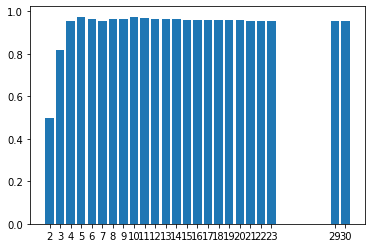

In [89]:
#ATIS
intent_hyp,intent_gt,slot_hyp,slot_gt=predict(ATIS_test_loader, ATIS_criterion_slots,
                                              ATIS_criterion_intents, ATIS_bigru, ATIS_lang)
#Slot is array of array, intent is array of strings

#Get an array of (predictions,ground truth) based on utterance length
intent_acc_lenght(intent_hyp,intent_gt, ATIS=True)

Accuracy at sentence lenght  3 = 0.8888888888888888
Accuracy at sentence lenght  4 = 0.8857142857142857
Accuracy at sentence lenght  5 = 0.9397590361445783
Accuracy at sentence lenght  6 = 0.9440993788819876
Accuracy at sentence lenght  7 = 0.9418604651162791
Accuracy at sentence lenght  8 = 0.9394812680115274
Accuracy at sentence lenght  9 = 0.9483568075117371
Accuracy at sentence lenght  10 = 0.9548254620123203
Accuracy at sentence lenght  11 = 0.9566003616636528
Accuracy at sentence lenght  12 = 0.9595278246205734
Accuracy at sentence lenght  13 = 0.960127591706539
Accuracy at sentence lenght  14 = 0.9600614439324117
Accuracy at sentence lenght  15 = 0.960960960960961
Accuracy at sentence lenght  16 = 0.9604105571847508
Accuracy at sentence lenght  17 = 0.9608127721335269
Accuracy at sentence lenght  18 = 0.9609826589595376
Accuracy at sentence lenght  19 = 0.9610951008645533
Accuracy at sentence lenght  20 = 0.9598278335724534
Accuracy at sentence lenght  21 = 0.9598853868194842
Ac

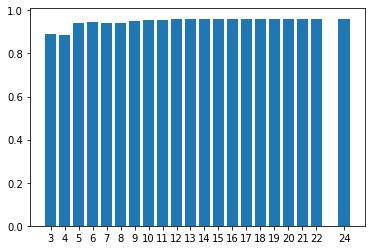

In [90]:
#SNIPS
intent_hyp,intent_gt,slot_hyp,slot_gt=predict(SNIPS_test_loader, SNIPS_criterion_slots,
                                              SNIPS_criterion_intents, SNIPS_bigru, SNIPS_lang)
#Slot is array of array, intent is array of strings
#Get an array of (predictions,ground truth) based on utterance length
intent_acc_lenght(intent_hyp,intent_gt, ATIS=False)

# 4) Third Model - Bert

In [20]:
from transformers import BertTokenizer, BertModel

### Hyperparameters

In [21]:
#Hyperparameters
max_length=50
train_batch_size=16
dev_batch_size=8
test_batch_size=8
epochs=10
learning_rate=0.00005
hidden_size=768 #Features generated by Bert encoder

PRE_TRAINED_MODEL_NAME='bert-base-uncased' #bert pretrained model I want to use

### Bert tokenization process

In [22]:
import transformers as transformers

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [23]:
example="My name is Jacopo and i would like to book a plane"
encodings=tokenizer.encode_plus(example,add_special_tokens=True,
                                max_length=max_length,
                               padding='max_length',
                               truncation=True,
                               return_attention_mask=True,
                               return_tensors='pt')

In [24]:
#encodings#Starts with CLS(101) and ends with SEP(102)
#Contains 3 tensors: input_ids ,token_type_ids ,attention_mask , need all 3 for training
#Bert tokenizer separates unknown words, for example Jacopo is broken into 3 separate tokens
#Sentence is padded to max_lenght, in this case 50

In [25]:
#tokenizer.convert_ids_to_tokens(encodings['input_ids'][0])

### Get dataset max sentence lenght

In [26]:
#Compute max lenght for padding size
def get_max_length(train,test):
    max_length=0
    for sent in train:
        current=len(sent['utterance'].split(" "))
        if current>max_length:
            max_length=current
    for sent in test:
        current=len(sent['utterance'].split(" "))
        if current>max_length:
            max_length=current
    return max_length

ATIS_tmp_train_raw = load_data(os.path.join('ATIS','train.json'))
ATIS_test_raw = load_data(os.path.join('ATIS','test.json'))
print(len(ATIS_tmp_train_raw))
print(len(ATIS_test_raw))

print(get_max_length(ATIS_tmp_train_raw,ATIS_test_raw))

SNIPS_tmp_train_raw = load_data(os.path.join('SNIPS','train.json'))
SNIPS_test_raw = load_data(os.path.join('SNIPS','test.json'))

print(get_max_length(SNIPS_tmp_train_raw,SNIPS_test_raw))

4978
893
46
35


### Dataloader

Since BERT uses a different token embedding, I've redone the dataloader functions using the BERT tokenizer

In [27]:
class BertLang():
    def __init__(self, intents, slots):
        self.word2id = self.load_bert_dict()
        self.slot2id = self.lab2id(slots)
        self.intent2id = self.lab2id(intents, pad=False)
        self.id2word = {v:k for k, v in self.word2id.items()}
        self.id2slot = {v:k for k, v in self.slot2id.items()}
        self.id2intent = {v:k for k, v in self.intent2id.items()}
        
    def load_bert_dict(self):
        vocab={}
        vocab_file = open('bert_vocab.txt', encoding="utf8")
        Lines = vocab_file.readlines()
        word_id = 0
        for line in Lines:
            word=line.rstrip()
            vocab[word]=word_id
            word_id += 1
        return vocab
    
    def lab2id(self, elements, pad=True):
        vocab = {}
        if pad:
            vocab['pad'] = PAD_TOKEN
        for elem in elements:
                vocab[elem] = len(vocab)
        return vocab
    
    def print_info(self):
        print("Vocab size:",len(self.word2id))
        print("Slot size:",len(self.slot2id)-1)
        print("Number of intents", len(self.intent2id))

In [28]:
class BERTDataset(torch.utils.data.Dataset):
    #def __init__(self, dataset, slots, intent, tokenizer, max_len):
    def __init__(self, dataset,lang,tokenizer,max_len):
        self.utterances = []
        self.slots = []
        self.intents = []
        self.lang=lang
        self.tokenizer = tokenizer
        self.max_len = max_len
        
        for x in dataset:
            utterance=x['utterance']
            utterance=utterance.replace("   "," ")#In SNIPS i noticed a problem in the dataset, some sentences have two or morewhitespaces
            utterance=utterance.replace("  "," ")#between words (example "play a tune or two from kansas city  missouri"  between city and missouri there are two whitespace)
                                                #since bert tokenizer wrongly recognize ' ' as a token, I remove the extra whitespace while loading
            self.utterances.append(utterance)
            
            self.slots.append(x['slots'])
            self.intents.append(x['intent'])

        self.slot_ids = self.mapping_seq(self.slots, lang.slot2id)
        self.intent_ids = self.mapping_lab(self.intents, lang.intent2id)
    
    def __len__(self):
        return len(self.utterances)
    
    def __getitem__(self, item):
        utterance = str(self.utterances[item])
        lang=self.lang
        intent = self.intent_ids[item]
        slots = self.slot_ids[item]
        slots_len = self.max_len,
        sent_len = len(slots)
        for i in range(sent_len,self.max_len):
            slots.append(PAD_TOKEN)
        encoding = self.tokenizer.encode_plus(
          utterance,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )
        return {
          'utterance': utterance,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),#'targets': torch.tensor(target, dtype=torch.long)
          'intent': intent,
          'slots_len': slots_len,
          'slots': torch.tensor(slots, dtype=torch.long)  
        }
    
    def mapping_lab(self, data, mapper):
        return [mapper[x] if x in mapper else mapper[self.unk] for x in data]
    
    def mapping_seq(self, data, mapper): # Map sequences to number
        res = []
        for seq in data:
            tmp_seq = []
            for x in seq.split():
                if x in mapper:
                    tmp_seq.append(mapper[x])
                else:
                    tmp_seq.append(mapper[self.unk])
            res.append(tmp_seq)
        return res

In [29]:
ATIS_corpus = ATIS_tmp_train_raw + ATIS_test_raw 
ATIS_slots = set(sum([line['slots'].split() for line in ATIS_corpus],[]))
ATIS_intents = set([line['intent'] for line in ATIS_corpus])

ATIS_lang = BertLang(ATIS_intents, ATIS_slots)

ATIS_train_dataset = BERTDataset(ATIS_train_raw, ATIS_lang, tokenizer, max_length)
ATIS_dev_dataset = BERTDataset(ATIS_dev_raw, ATIS_lang, tokenizer, max_length)
ATIS_test_dataset = BERTDataset(ATIS_test_raw, ATIS_lang, tokenizer, max_length)

In [30]:
SNIPS_corpus = SNIPS_tmp_train_raw + SNIPS_test_raw 
SNIPS_slots = set(sum([line['slots'].split() for line in SNIPS_corpus],[]))
SNIPS_intents = set([line['intent'] for line in SNIPS_corpus])

SNIPS_lang = BertLang(SNIPS_intents, SNIPS_slots)

SNIPS_train_dataset = BERTDataset(SNIPS_train_raw, SNIPS_lang, tokenizer, max_length)
SNIPS_dev_dataset = BERTDataset(SNIPS_dev_raw, SNIPS_lang, tokenizer, max_length)
SNIPS_test_dataset = BERTDataset(SNIPS_test_raw, SNIPS_lang, tokenizer, max_length)

In [31]:
#print(ATIS_train_dataset.__getitem__(456))

#input id traduce la frase con il vocab di bert

In [32]:
def create_data_loader(dataset,batch_size):
    return DataLoader(dataset,batch_size=batch_size,shuffle=True)

ATIS_train_dataloader = create_data_loader(ATIS_train_dataset, train_batch_size)
ATIS_dev_dataloader = create_data_loader(ATIS_dev_dataset, dev_batch_size)
ATIS_test_dataloader = create_data_loader(ATIS_test_dataset, test_batch_size)

SNIPS_train_dataloader = create_data_loader(SNIPS_train_dataset, train_batch_size)
SNIPS_dev_dataloader = create_data_loader(SNIPS_dev_dataset, dev_batch_size)
SNIPS_test_dataloader = create_data_loader(SNIPS_test_dataset, test_batch_size)

#print(len(ATIS_train_dataloader),train_batch_size)
print("ATIS")
print("Train: ",len(ATIS_train_dataloader)*train_batch_size)
print("Dev: ",len(ATIS_dev_dataloader)*dev_batch_size)
print("Test: ",len(ATIS_test_dataloader)*test_batch_size)
print("="*85)
print("SNIPS")
print("Train: ",len(SNIPS_train_dataloader)*train_batch_size)
print("Dev: ",len(SNIPS_dev_dataloader)*dev_batch_size)
print("Test: ",len(SNIPS_test_dataloader)*test_batch_size)

ATIS
Train:  4384
Dev:  600
Test:  896
SNIPS
Train:  11648
Dev:  1440
Test:  704


### Bert Model

In [33]:
class BertJoint(nn.Module):
    def __init__(self,hid_size, out_slot, out_int):
        super(BertJoint,self).__init__()
        self.bert_encoder= BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=True)
        
        self.slot_out = nn.Linear(hid_size, out_slot)
        self.intent_out = nn.Linear(hid_size, out_int)
        #self.dropout=nn.Dropout(0.3)
    
    def forward(self, input_ids, attention_mask):
        outputs= self.bert_encoder(input_ids=input_ids,attention_mask=attention_mask)
        #returns sequence_output, pooled_output, (hidden_states), (attentions)
        
        sequence_output = outputs[0]
        pooled_output = outputs[1] 

        intents = self.intent_out(pooled_output)
        slots = self.slot_out(sequence_output)
        
        #Slot size: batch size, seq len, classes
        slots = slots.permute(0,2,1) #Used for computing the loss
        # Slot size: batch_size, classes, seq_len
        
        return slots, intents

### Training Bert

In [34]:
ATIS_criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
ATIS_criterion_intents = nn.CrossEntropyLoss()

SNIPS_criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
SNIPS_criterion_intents = nn.CrossEntropyLoss()

ATIS_out_slot = len(ATIS_lang.slot2id)
ATIS_out_int = len(ATIS_lang.intent2id)
ATIS_vocab_len = len(ATIS_lang.word2id)

SNIPS_out_slot = len(SNIPS_lang.slot2id)
SNIPS_out_int = len(SNIPS_lang.intent2id)
SNIPS_vocab_len = len(SNIPS_lang.word2id)

In [35]:
#ATIS
ATIS_model=BertJoint(hidden_size,ATIS_out_slot,ATIS_out_int)
ATIS_model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertJoint(
  (bert_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

In [36]:
#SNIPS
SNIPS_model=BertJoint(hidden_size,SNIPS_out_slot,SNIPS_out_int)
SNIPS_model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertJoint(
  (bert_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

In [37]:
#ATIS
ATIS_optimizer= torch.optim.AdamW(params=ATIS_model.parameters(),lr=learning_rate)
ATIS_total_steps=len(ATIS_train_dataloader)*epochs
ATIS_scheduler=transformers.get_linear_schedule_with_warmup(ATIS_optimizer,num_warmup_steps=0,num_training_steps=ATIS_total_steps)

#SNIPS
SNIPS_optimizer= torch.optim.AdamW(params=SNIPS_model.parameters(),lr=learning_rate)
SNIPS_total_steps=len(SNIPS_train_dataloader)*epochs
SNIPS_scheduler=transformers.get_linear_schedule_with_warmup(SNIPS_optimizer,num_warmup_steps=0,num_training_steps=SNIPS_total_steps)

In [38]:
def train_epoch(model,data_loader,intent_criterion,slots_criterion,optimizer,device,scheduler):
    
    model=model.train()
    
    loss_array = []
    
    for d in data_loader:
        optimizer.zero_grad()
        input_id=d['input_ids'].to(device)
        attention_mask=d['attention_mask'].to(device)
        intent_gt=d['intent'].to(device)
        slot_gt=d['slots'].to(device)
        
        slot_pred,intent_pred=model(input_ids=input_id, attention_mask=attention_mask)
        
        loss_intent=intent_criterion(intent_pred,intent_gt)
        
        loss_slot=slots_criterion(slot_pred,slot_gt)
        
        #loss=loss_intent+loss_slot
        
        alpha=random.uniform(0, 1)
        beta=1-alpha
        
        loss=max(alpha,beta) * loss_slot + min(alpha,beta) * loss_intent
        
        loss_array.append(loss.item())
        loss.backward() # Compute the gradient, deleting the computational graph
        # clip the gradient to avoid explosioning gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  
        optimizer.step() # Update the weights
        scheduler.step()
        
    return loss_array

In [39]:
def eval_bert(model, data_loader, intent_criterion,slots_criterion, lang,device):
    model = model.eval()
    
    loss_array = []
    
    ref_intents = []
    hyp_intents = []
    
    y_slots = []
    hyp_slots = []
    
    with torch.no_grad():
        for sample in data_loader:
            input_ids = sample["input_ids"].to(device)
            attention_mask = sample["attention_mask"].to(device)
            ref_slots = sample["slots"].to(device)
            ref_intent = sample["intent"].to(device)

            slots, intents = model(input_ids=input_ids,attention_mask=attention_mask)
            
            loss_intent = intent_criterion(intents, ref_intent)
            loss_slot = slots_criterion(slots, ref_slots)
            loss = loss_intent + loss_slot
            
            loss_array.append(loss.item())
            
            # Intent inference
            # Get the highest probable class
            out_intents = [lang.id2intent[x] 
                           for x in torch.argmax(intents, dim=1).tolist()] 
            gt_intents = [lang.id2intent[x] for x in sample['intent'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)
            
            
            # Slot inference 
            output_slots = torch.argmax(slots, dim=1) #Returns the indices of the maximum value of all elements in the input tensor.
            ref_slots=ref_slots.tolist()
            slots_len=len(ref_slots)
            
            
            for id_seq, seq in enumerate(output_slots):#id_seq è il sample, seq è l'indice dello slot(id dello slot)
                length = sample['slots_len'][0].data[0].item()
                utterance = sample['utterance'][id_seq].split(" ")
                
                gt_ids = sample['slots'][id_seq].tolist()
                gt_slots = [lang.id2slot[elem] for elem in gt_ids]
                
                #Compute
                tmp_ref=[]
                for id_el in range(0,length):
                    if(id_el<len(utterance)):
                        tmp_ref.append((utterance[id_el], gt_slots[id_el]))
                y_slots.append(tmp_ref)
                
                
                slot_ids=seq.tolist()
                
                tmp_seq = []
                for id_el in range(0,length):
                    if(id_el<len(utterance)):
                        tmp_seq.append((utterance[id_el], lang.id2slot[slot_ids[id_el]]))
                hyp_slots.append(tmp_seq)
    try:
        results = evaluate(y_slots, hyp_slots)
    except Exception as ex:
        # Sometimes the model predics a class that is not in REF
        print(ex)
        ref_s = set([x[1] for x in ref_slots])
        hyp_s = set([x[1] for x in hyp_slots])
        print(hyp_s.difference(ref_s))
        
    report_intent = classification_report(ref_intents, hyp_intents, 
                                          zero_division=False, output_dict=True)
    return results, report_intent, loss_array                

### Save and load model methods
Since Bert training is more heavy on the hardware (15~20 minutes for 10 epochs on my setup for one dataset) I save trained models locally and load them for evaluation and error analysis

In [40]:
DIR_MODELS="bert_models"

In [41]:
def save_bert(model,atis):
    #model --> model to save
    #atis=true --> model is trained on atis dataset
    #atis=false --> model is trained on snips dataset
    if(atis):
        model_name="ATIS"
    else:
        model_name="SNIPS"
    path=os.path.join(DIR_MODELS,model_name)
    torch.save(model.state_dict(), path)
    print("Model saved in",path)

In [42]:
def load_bert(atis):
    #atis=true --> load atis model
    #atis=false --> load snips model
    hid_size=hidden_size
    if(atis):
        model_name="atis_bert.pt"
        out_slot=ATIS_out_slot
        out_int=ATIS_out_int
    else:
        model_name="snips_bert.pt"
        out_slot=SNIPS_out_slot
        out_int=SNIPS_out_int
    path=os.path.join(DIR_MODELS,model_name)
    print("Loading model from",path)
    
    model=BertJoint(hidden_size,out_slot,out_int).to(device)
    model.load_state_dict(torch.load(path))
    model.eval()
    
    return model

### Training procedure

In [43]:
#ATIS
warnings.filterwarnings('ignore')#Used to ignore a warning from hugging face tokenizer that would get repeated at every epoch, gets displayed only firstime

update_tick=100/epochs
with tqdm(total=100) as pbar:#updating tqdm manually for clearer visualization
    for epoch in range(1, epochs+1):
        train_loss = train_epoch(
        ATIS_model,
        ATIS_train_dataloader,
        ATIS_criterion_intents,
        ATIS_criterion_slots,
        ATIS_optimizer,
        device,
        ATIS_scheduler)

        results_dev, intent_res, loss_dev  = eval_bert(
        ATIS_model,
        ATIS_dev_dataloader,
        ATIS_criterion_intents,
        ATIS_criterion_slots,
        ATIS_lang,
        device)
        
        test_results_dev, test_intent_res, test_loss_dev  = eval_bert(
        ATIS_model,
        ATIS_test_dataloader,
        ATIS_criterion_intents,
        ATIS_criterion_slots,
        ATIS_lang,
        device)

        print("Epoch:",epoch)
        print(f'Train loss {mean(train_loss)}')
        print('Dev Slot F1: ', results_dev['total']['f'])
        print('Dev Intent Accuracy:', intent_res['accuracy'])
        
        print('Test Slot F1: ', test_results_dev['total']['f'])
        print('Test Intent Accuracy:', test_intent_res['accuracy'])

        pbar.update(update_tick)#updating tqdm manually for clearer visualization

print("Saving model...")
save_model(ATIS_model,atis=True)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
 10%|███████▉                                                                       | 10.0/100 [01:03<09:35,  6.39s/it]

Epoch: 1
Train loss 0.718723860344965
Dev Slot F1:  0.8583647798742139
Dev Intent Accuracy: 0.9547738693467337
Test Slot F1:  0.8159660897209465
Test Intent Accuracy: 0.8779395296752519


 20%|███████████████▊                                                               | 20.0/100 [02:07<08:31,  6.39s/it]

Epoch: 2
Train loss 0.21017269927491672
Dev Slot F1:  0.93158953722334
Dev Intent Accuracy: 0.966499162479062
Test Slot F1:  0.8848996832101373
Test Intent Accuracy: 0.8868980963045913


 30%|███████████████████████▋                                                       | 30.0/100 [03:11<07:25,  6.36s/it]

Epoch: 3
Train loss 0.11174532259223018
Dev Slot F1:  0.9483967935871744
Dev Intent Accuracy: 0.9782244556113903
Test Slot F1:  0.8985405310356954
Test Intent Accuracy: 0.9428891377379619


 40%|███████████████████████████████▌                                               | 40.0/100 [04:14<06:20,  6.34s/it]

Epoch: 4
Train loss 0.06966114840062376
Dev Slot F1:  0.9514514514514515
Dev Intent Accuracy: 0.9899497487437185
Test Slot F1:  0.9096966508854988
Test Intent Accuracy: 0.973124300111982


 50%|███████████████████████████████████████▌                                       | 50.0/100 [05:17<05:17,  6.34s/it]

Epoch: 5
Train loss 0.044197611806465545
Dev Slot F1:  0.9574787393696848
Dev Intent Accuracy: 0.9865996649916248
Test Slot F1:  0.9170320996316437
Test Intent Accuracy: 0.975363941769317


 60%|███████████████████████████████████████████████▍                               | 60.0/100 [06:20<04:13,  6.33s/it]

Epoch: 6
Train loss 0.03207153134918126
Dev Slot F1:  0.9676286072772897
Dev Intent Accuracy: 0.9882747068676717
Test Slot F1:  0.9248412138320397
Test Intent Accuracy: 0.9764837625979843


 70%|███████████████████████████████████████████████████████▎                       | 70.0/100 [07:26<03:12,  6.40s/it]

Epoch: 7
Train loss 0.022345726652730283
Dev Slot F1:  0.9666248431618569
Dev Intent Accuracy: 0.9865996649916248
Test Slot F1:  0.9231311706629056
Test Intent Accuracy: 0.9764837625979843


 80%|███████████████████████████████████████████████████████████████▏               | 80.0/100 [08:30<02:08,  6.41s/it]

Epoch: 8
Train loss 0.017234322632387635
Dev Slot F1:  0.9669172932330826
Dev Intent Accuracy: 0.9882747068676717
Test Slot F1:  0.9249735822472702
Test Intent Accuracy: 0.9764837625979843


 90%|███████████████████████████████████████████████████████████████████████        | 90.0/100 [09:33<01:03,  6.39s/it]

Epoch: 9
Train loss 0.01312708469272598
Dev Slot F1:  0.9684052156469408
Dev Intent Accuracy: 0.9882747068676717
Test Slot F1:  0.9246213455442057
Test Intent Accuracy: 0.9764837625979843


100%|██████████████████████████████████████████████████████████████████████████████| 100.0/100 [10:37<00:00,  6.37s/it]

Epoch: 10
Train loss 0.009858585001023854
Dev Slot F1:  0.9691497366440932
Dev Intent Accuracy: 0.9882747068676717
Test Slot F1:  0.9258149779735684
Test Intent Accuracy: 0.975363941769317
Saving model...


Model saved in bert_models\atis_bert.pt


In [45]:
#SNIPS
warnings.filterwarnings('ignore')#Used to ignore a warning from hugging face tokenizer that would get repeated at every epoch, gets displayed only firstime

update_tick=100/epochs
with tqdm(total=100) as pbar:#updating tqdm manually for clearer visualization
    for epoch in range(1, epochs+1):
        train_loss = train_epoch(
        SNIPS_model,
        SNIPS_train_dataloader,
        SNIPS_criterion_intents,
        SNIPS_criterion_slots,
        SNIPS_optimizer,
        device,
        SNIPS_scheduler)


        results_dev, intent_res, loss_dev  = eval_bert(
        SNIPS_model,
        SNIPS_dev_dataloader,
        SNIPS_criterion_intents,
        SNIPS_criterion_slots,
        SNIPS_lang,
        device)

        test_results_dev, test_intent_res, test_loss_dev  = eval_bert(
            SNIPS_model,
            SNIPS_test_dataloader,
            SNIPS_criterion_intents,
            SNIPS_criterion_slots,
            SNIPS_lang,
            device)
    
    
        print("Epoch:",epoch)
        print(f'Train loss {mean(train_loss)}')
        print('Slot F1: ',results_dev['total']['f'])
        print('Intent Accuracy:', intent_res['accuracy'])

        print('Test Slot F1: ', test_results_dev['total']['f'])
        print('Test Intent Accuracy:', test_intent_res['accuracy'])

        pbar.update(update_tick)#updating tqdm manually for clearer visualization
    
print("Saving model...")
save_model(SNIPS_model,atis=False)

 10%|███████▉                                                                       | 10.0/100 [02:38<23:49, 15.89s/it]

Epoch: 1
Train loss 0.5741822937667206
Slot F1:  0.8309517390132111
Intent Accuracy: 0.9826388888888888
Test Slot F1:  0.8028993587956511
Test Intent Accuracy: 0.97


 20%|███████████████▊                                                               | 20.0/100 [05:22<21:32, 16.15s/it]

Epoch: 2
Train loss 0.155387786009789
Slot F1:  0.8762720942688806
Intent Accuracy: 0.9826388888888888
Test Slot F1:  0.8514742353265362
Test Intent Accuracy: 0.9842857142857143


 30%|███████████████████████▋                                                       | 30.0/100 [08:04<18:53, 16.19s/it]

Epoch: 3
Train loss 0.09259291354612867
Slot F1:  0.9124214467174756
Intent Accuracy: 0.9888888888888889
Test Slot F1:  0.8845941468801768
Test Intent Accuracy: 0.9842857142857143


 40%|███████████████████████████████▌                                               | 40.0/100 [10:43<16:04, 16.07s/it]

Epoch: 4
Train loss 0.06059806827765347
Slot F1:  0.9114534494306765
Intent Accuracy: 0.9881944444444445
Test Slot F1:  0.8981737686773659
Test Intent Accuracy: 0.98


 50%|███████████████████████████████████████▌                                       | 50.0/100 [13:23<13:22, 16.04s/it]

Epoch: 5
Train loss 0.03878593348765587
Slot F1:  0.9255091103965701
Intent Accuracy: 0.9902777777777778
Test Slot F1:  0.9083863825076114
Test Intent Accuracy: 0.9842857142857143


 60%|███████████████████████████████████████████████▍                               | 60.0/100 [16:06<10:45, 16.14s/it]

Epoch: 6
Train loss 0.027303120336360374
Slot F1:  0.9224993295789757
Intent Accuracy: 0.9888888888888889
Test Slot F1:  0.9155086158977209
Test Intent Accuracy: 0.9814285714285714


 70%|███████████████████████████████████████████████████████▎                       | 70.0/100 [18:51<08:07, 16.24s/it]

Epoch: 7
Train loss 0.016959556388098793
Slot F1:  0.9310576535411907
Intent Accuracy: 0.9909722222222223
Test Slot F1:  0.9162506932889629
Test Intent Accuracy: 0.98


 80%|███████████████████████████████████████████████████████████████▏               | 80.0/100 [21:33<05:24, 16.23s/it]

Epoch: 8
Train loss 0.010071802263085444
Slot F1:  0.9364224137931035
Intent Accuracy: 0.9895833333333334
Test Slot F1:  0.9252649191299498
Test Intent Accuracy: 0.9842857142857143


 90%|███████████████████████████████████████████████████████████████████████        | 90.0/100 [24:12<02:41, 16.13s/it]

Epoch: 9
Train loss 0.006681728353234556
Slot F1:  0.9341751746372918
Intent Accuracy: 0.9895833333333334
Test Slot F1:  0.920935412026726
Test Intent Accuracy: 0.9828571428571429


100%|██████████████████████████████████████████████████████████████████████████████| 100.0/100 [26:51<00:00, 16.11s/it]

Epoch: 10
Train loss 0.004288000444720747
Slot F1:  0.9354795439302481
Intent Accuracy: 0.9909722222222223
Test Slot F1:  0.9254727474972192
Test Intent Accuracy: 0.9814285714285714
Saving model...


Model saved in bert_models\snips_bert.pt


### Testing

Il load da checkpoint non funziona

In [ ]:
#Load saved bert models

ATIS_bert=load_model(atis=True)
SNIPS_bert=load_model(atis=False)

In [ ]:
ATIS_results_test, ATIS_intent_test, _ = eval_bert(ATIS_bert, ATIS_test_dataloader, ATIS_criterion_intents, 
                                                   ATIS_criterion_slots, ATIS_lang,device)
print("ATIS")
print('Slot F1: ',ATIS_results_test['total']['f'])
print('Intent Accuracy:', ATIS_intent_test['accuracy'])


SNIPS_results_test, SNIPS_intent_test, _ = eval_bert(SNIPS_bert, SNIPS_test_dataloader, SNIPS_criterion_intents, 
                                                   SNIPS_criterion_slots, SNIPS_lang,device)

print("SNIPS")
print('Slot F1: ',SNIPS_results_test['total']['f'])
print('Intent Accuracy:', SNIPS_intent_test['accuracy'])

### Error Analysis

In [ ]:
#ATIS
intent_hyp,intent_gt,slot_hyp,slot_gt=predict(ATIS_test_loader, ATIS_criterion_slots,
                                              ATIS_criterion_intents, ATIS_bigru, ATIS_lang)
#Slot is array of array, intent is array of strings

#Get an array of (predictions,ground truth) based on utterance length
intent_acc_lenght(intent_hyp,intent_gt, ATIS=True)